<a id='top'></a>
## Can Amazon Reviews Help Businesses Learn their Best Customers? 

#### Contributors: Muoyo Okome, Jill Carrie

<a id='toc'></a>
### Table of Contents
1. [Problem Statement](#problemstatement)
2. [Data Sources](#datasources)
3. [Data Cleaning](#datacleaning)
4. [Multicollinearity](#multicollinearity)  
4. [Linear Regression](#regression)  
5. [Findings](#findings)
6. [Vizualizations](#findings)
7. [Next Steps](#nextsteps)

In [1]:
# Import necessary libraries
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

<a id='problemstatement'></a>
### Problem Statement

**Can Amazon Reviews Help Businesses Learn their Best Customers?**

The key question we look to answer is whether knowing the text of an Amazon Customer Review can help us predict the star rating of that review.

Eventually our goal is to provide these insights to businesses as a service to help them identify customers most likely to love or hate their products based on the things they are saying.

[Back to Top ↑](#top)

<a id='datasources'></a>
### Data Sources

#### **[AWS Open Data: Amazon Customer Reviews Dataset](https://registry.opendata.aws/amazon:reviews/)**

- Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazon’s iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. Over 130+ million customer reviews are available to researchers as part of this dataset.

- A collection of reviews written in the Amazon.com marketplace and associated metadata from 1995 until 2015. This is intended to facilitate study into the properties (and the evolution) of customer reviews potentially including how people evaluate and express their experiences with respect to products at scale. (130M+ customer reviews) 

<br> 

[Back to Top ↑](#top)

In [2]:
# Import python files we've created to help
%run ../python_files/utils
%run ../python_files/regression
%run ../python_files/data_cleaning
%run ../python_files/visualizations

In [3]:
# Read in original data: 1 million records
df = get_trip_records(limit=1000000)

<a id='datacleaning'></a>
### Data Cleaning

Before beginning our analysis, we performed a number of operations to get the data ready to work with, including, but not limited to: 

- Limiting trip data to the columns we were most interested in: **'trip_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds', 'trip_miles', 'pickup_community_area', 'fare', 'tip', 'additional_charges', 'trip_total'**

- Converting numeric & timestamp data from strings to the appropriate datatypes

- Imputing missing values with the median, 0, or "missing" depending on what made the most sense for each particular variable

We then created columns for the weekday, hour, and time block when the trip was initiated (There are 8 three hour time blocks in each 24 hour day, with block 0 starting at 12AM) and also combined this information into the **start_date_plus hour** column which we then used to merge trip data with weather data at the hourly level. We've pulled in 425 days of hour-by-hour weather data from Chicago, obtained via the Dark Sky API and our WeatherGetter class, which you can see at work in **weather.ipynb** and then saved it to a CSV.

To make the project more modular and easier to follow & build upon, we created separate .py files to handle the heavy lifting for tasks such as data extraction & cleaning, visualizations, and linear regressions. We also created a function called **get_random_samples()** (located in **utils.py**), which allows us to draw random samples of trip data from the Socrata API. Please note that random sampling takes significantly longer than the alternative, due to the fact that we are running many queries instead of one, and there is a certain amount of overhead for each query irrespective of record size.

In [4]:
# Clean data & load into final dataframe

In [5]:
df = clean_data(df)



[Back to Top ↑](#top)

<a id='multicollinearity'></a>
### Multicollinearity of Features

Prior to regression, we want to be aware of any linear relationships between independent variables that could affect our results. As one might expect, **trip_seconds** and **trip_miles** are strongly correlated. Ultimately, we won't be using either for our final analysis, as that information would not be available to our stakeholders, the drivers. However it is interesting to know. The rest of our variables do not appear to suffer from multicollinearity, as we can deduce from the pairplot and heatmap visualizations below.

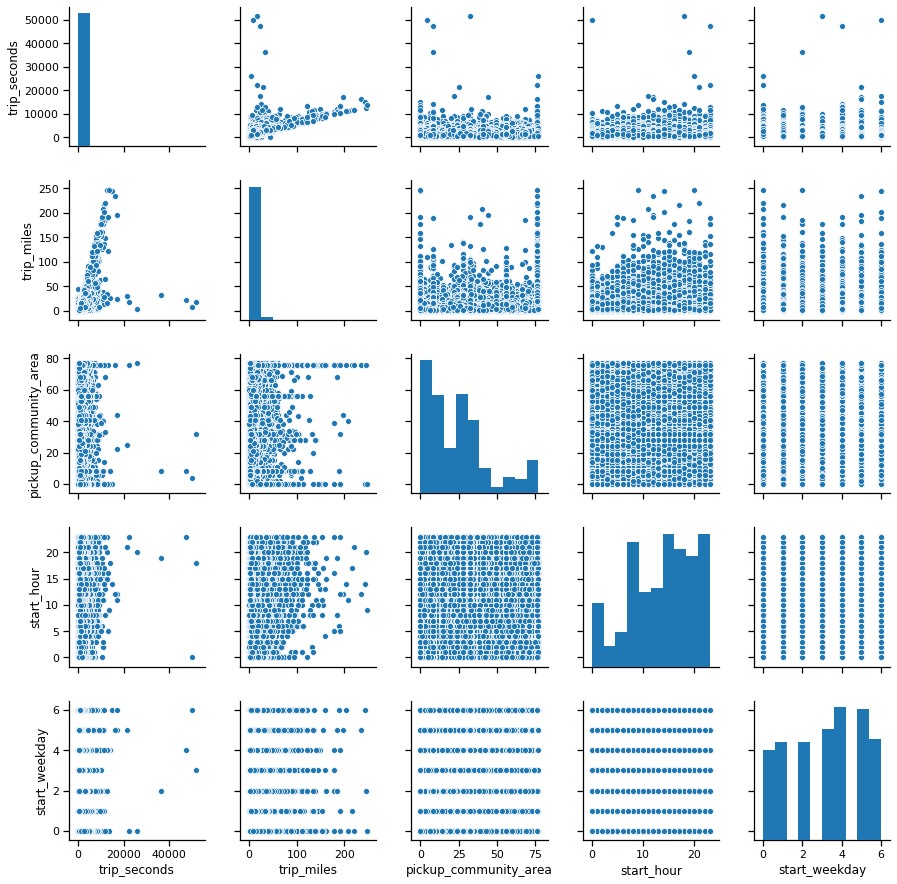

In [6]:
df_corr = df[['trip_seconds', 'trip_miles', 'pickup_community_area', 'start_hour', 'start_weekday']]
sns.pairplot(df_corr)



[Back to Top ↑](#top)

<a id='regression'></a>
### Linear Regression

For our predictive analysis we leveraged the tool of linear regression using the following parameters:

- **Dependent variable:** **'trip_total'** (OR in some cases we instead looked at **'fare'**)<p>

- **Independendent variables:**
    - **'apparentTemperature'**
    - **'start_weekday'**
    - **'start_hour'** (OR in some cases we instead looked at **'start_time_block'**)
    - **'pickup_community_area'** (Chicago is divided into 77 community areas, each of which belongs to one of nine "sides")


We assume that our predictor variables have a linear relation with our dependent variable, that the residuals of our model follow a normal distribution, and that the dependent variable's variance is equal across all values of the independent variable.

Before performing the regression, we preprocessed the data using the following steps:

- Splitting out continuous (temperature) & categorical variables (the rest of the independent variables) to be dealt with separately.

- Splitting data into training and test sets. We reserved 25% of our data for testing purposes, meaning that we do not work with it until after our model is finalized, to avoid data leakage.

- Performing one hot encoding on our categorical variables to make usable for linear regression.

- Combining our categorical and continuous features back into a final dataframe.


In [8]:
X_train, X_test, y_train, y_test = get_train_test_split(df, test_size=.25)

### Ordinary Least Squares via statsmodels

With our preprocessing complete (we conduct it within the **get_train_test_split()** function, as seen above), we are ready to run our series of regression. 

First, we run an OLS regression using statsmodels and learn that our model explains 26-30% of the variance of our independent variable **trip_total**, depending on the specific set of data we are working with.

In [9]:
OLS(y_train, X_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             trip_total   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3037.
Date:                Mon, 27 Jan 2020   Prob (F-statistic):               0.00
Time:                        21:56:21   Log-Likelihood:            -2.7284e+06
No. Observations:              750000   AIC:                         5.457e+06
Df Residuals:                  749908   BIC:                         5.458e+06
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
apparentTemperature            0.0106      0.001     14.707      0.000       0.009       0.012
start_weekday_0.0              7.1448      0.032    222.256      0.000       7.082       7.208
start_weekday_1.0              6.6537      0.031    214.975      0.000       6.593       6.714
start_weekday_2.0              6.6582      0.031    211.626      0.000       6.597       6.720
start_weekday_3.0              7.2389      0.031    237.284      0.000       7.179       7.299
start_weekday_4.0              7.2188      0.028    259.030      0.000       7.164       7.273
start_weekday_5.0              6.9139      0.029    240.617      0.000       6.858       6.970
start_weekday_6.0              6.6394      0.031    213.526      0.000       6.579       6.700
start_time_block_0.0           4.9954      0.040    125.471      0.000       4.917       5.073
start_time_block_1.0           9.1630      0.052    174.746      0.000       9.060       9.266
start_time_block_2.0           7.0339      0.032    222.766      0.000       6.972       7.096
start_time_block_3.0           5.7385      0.030    189.073      0.000       5.679       5.798
start_time_block_4.0           5.9689      0.031    193.563      0.000       5.908       6.029
start_time_block_5.0           5.9311      0.028    208.388      0.000       5.875       5.987
start_time_block_6.0           4.8177      0.027    177.945      0.000       4.765       4.871
start_time_block_7.0           4.8192      0.029    163.469      0.000       4.761       4.877
pickup_community_area_0.0     12.9439      0.050    258.530      0.000      12.846      13.042
pickup_community_area_1.0      0.2215      0.098      2.255      0.024       0.029       0.414
pickup_community_area_2.0     -0.7594      0.116     -6.544      0.000      -0.987      -0.532
pickup_community_area_3.0     -0.2985      0.076     -3.948      0.000      -0.447      -0.150
pickup_community_area_4.0      0.1663      0.102      1.638      0.101      -0.033       0.365
pickup_community_area_5.0     -0.0116      0.096     -0.121      0.904      -0.200       0.177
pickup_community_area_6.0     -0.5926      0.047    -12.577      0.000      -0.685      -0.500
pickup_community_area_7.0     -1.1456      0.051    -22.403      0.000      -1.246      -1.045
pickup_community_area_8.0     -0.4377      0.036    -12.243      0.000      -0.508      -0.368
pickup_community_area_9.0      2.0928      0.358      5.850      0.000       1.392       2.794
pickup_community_area_10.0     1.0819      0.196      5.520      0.000       0.698       1.466
pickup_community_area_11.0     0.8438      0.204      4.131      0.000       0.443       1.244
pickup_community_area_12.0     3.0744      0.302     10.166      0.000       2.482       3.667
pickup_community_area_13.0     0.0755      

Looking at the p-values for the coefficients, we can see that most of the variables are significant. 

However, our model does suffer from issues with the Jarque-Bera test, as well as the F-statistic, indicating that errors are not likely to be normally distributed, and the homoscedasticity assumption is likely to be violated. We need to focus on addressing these issues in our future analysis, perhaps using log transformations as a starting point.

### Ridge & Lasso via scikit-learn

We attempted to see whether we could get any improvement in predictive by using Ridge or Lasso to reduce model variance. Unfortunately, neither one helped us, no matter the value of lambda/alpha with Lasso canceling every variable but one, yielding an R-squared of essentially 0, and Ridge making little to no changes to our model coefficients or R-squared.

In [10]:
lasso = Lasso(X_train, y_train)
lasso.coef_

Training r^2: 0.00015629742404010827
Training MSE: 115.73685735520652


array([ 0.00555097,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.  

In [11]:
ridge = Ridge(X_train, y_train)
ridge.coef_

Training r^2: 0.2692902385915754
Training MSE: 84.58327157164737


array([ 1.05576264e-02,  2.21042414e-01, -2.70227372e-01, -2.65692166e-01,
        3.14968946e-01,  2.94689337e-01, -1.03219767e-02, -2.84459183e-01,
       -1.06267420e+00,  3.10343578e+00,  9.74937337e-01, -3.19881915e-01,
       -8.93876836e-02, -1.27223404e-01, -1.24041991e+00, -1.23878601e+00,
        1.23232163e+01, -3.95874045e-01, -1.37505760e+00, -9.15758656e-01,
       -4.51003752e-01, -6.28851295e-01, -1.21026874e+00, -1.76300105e+00,
       -1.05548774e+00,  1.45253068e+00,  4.62014873e-01,  2.24839512e-01,
        2.42983252e+00, -5.39341343e-01, -7.19261087e-01, -2.09075913e-01,
       -6.35044790e-01,  1.44935946e-01, -6.53255928e-01, -1.65416258e+00,
       -1.32862825e+00, -1.30655847e+00, -1.66766202e+00, -1.86047660e+00,
       -2.10776124e+00, -1.23839977e+00, -2.03876907e+00, -2.21791627e+00,
       -1.60225262e+00, -1.77482253e+00, -1.46891109e+00, -2.16582911e+00,
       -7.73026088e-02,  5.05695204e-01, -1.62357059e+00, -2.12351611e+00,
       -1.59215971e+00, -

[Back to Top ↑](#top)

<a id='findings'></a>
### Findings

1. **Drivers can earn the most at 5 am.** Peak fares occur between 4-6am on a daily basis. Across all the 7 days of the week, the peak earning time for drivers is always between 4-6 am. Factors that can help explain this trend is the fact that to earn more drivers are looking at driving long distances in less amount of time, early mornings provide an opportunity for long distances mostly to airports and relatively less traffic hence distance can be covered in shorter periods of time.<p>

2. **Airport pickups lead to higher earnings.** The 2 airports in Chicago are by far the highest earning pickup community areas, Neighborhoods that are far from the airport and with limited public transport lead the rest of the other community areas.<p>

3. **Day of week alone does not significantly affect expected fare.** Average fares tend to fall in the same range when viewed at the daily level. We need to combine with other predictors to get a better sense of the true relationships.<p>

4. **Strong relationship between temperature and trip fare. Of the independent variables used, Temperature has the strongest correlation with Fares. The colder it gets the more average fares increase**<p>



[Back to Top ↑](#top)

<a id='visualizations'></a>
### Visualizations

Let's further illustrate our findings via the illustrations below.

### Peak fares occur between 4am - 6am

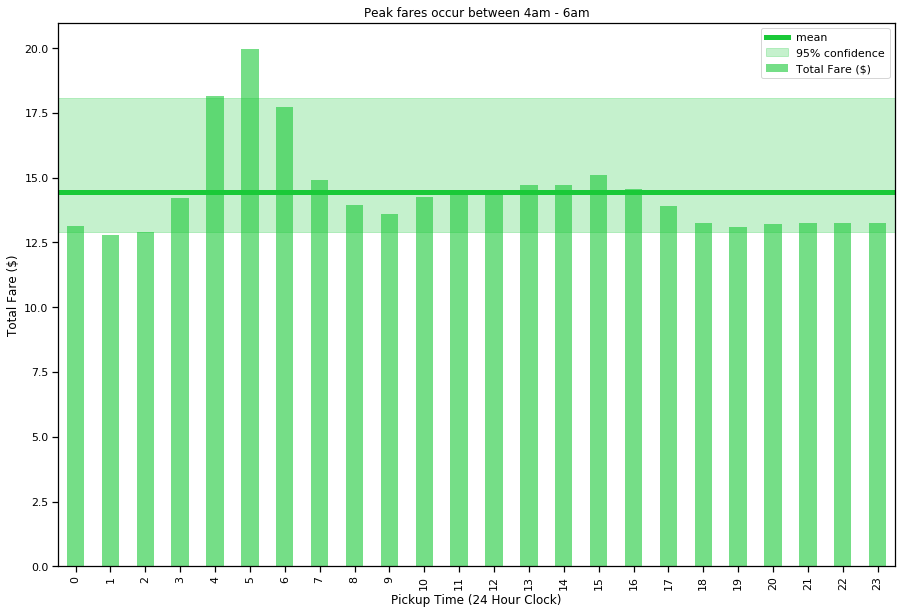

In [12]:
barplot(df.groupby('start_hour')['trip_total'].mean(), title='Peak fares occur between 4am - 6am', 
                                                       xlabel='Pickup Time (24 Hour Clock)', ylabel='Total Fare ($)', figsize=(15,10));

### Airport pickups yield the highest fares



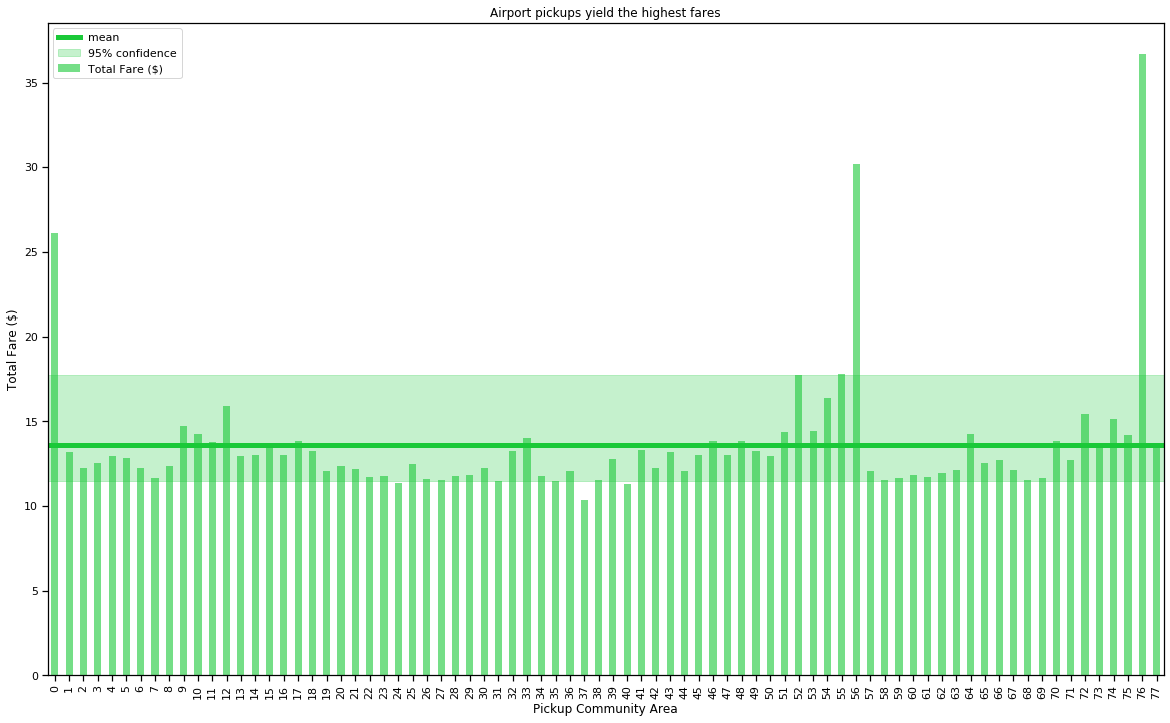

In [13]:
barplot(df.groupby('pickup_community_area')['trip_total'].mean(), title='Airport pickups yield the highest fares', 
                                                                  xlabel='Pickup Community Area', ylabel='Total Fare ($)', figsize=(20, 12));

### Day of week alone does not significantly affect expected fare

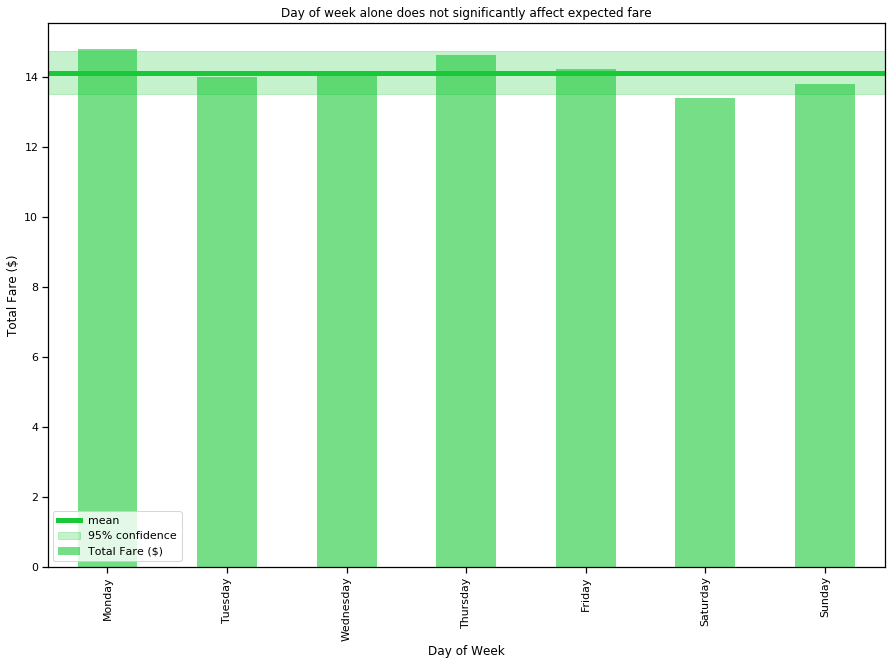

In [14]:
barplot(df.groupby('start_weekday')['trip_total'].mean(), title='Day of week alone does not significantly affect expected fare', 
                                                          xlabel='Day of Week', ylabel='Total Fare ($)', figsize=(15, 10));
plt.xticks(range(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'));



[Back to Top ↑](#top)

<a id='nextsteps'></a>
### Next Steps

1. **Further refine the model to provide recommendations of ideal pickup location given time & weather.** To be able to provide drivers realtime predictions of where and when to be in order to earn the most, using their location, weather conditions, time and day of the week.<p>

2. **Finding additional and more correct independent variables to increase models predictive power** that may include events and activities going on in Chicago, emergencies, data on airport arrivals and delays, etc.<p>

3. **Extend our model to help different groups such as riders & competing rideshare companies.** Can we design models that can help riders to determine when a fee will drop and by how much to help them make better decisions of when to take a ride that will save them the most money?<p>



[Back to Top ↑](#top)